In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
import IPython
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

def minimize_remainder(arr, min_div, max_div):
    divisors = np.linspace(min_div, max_div, num=100)
    remainders = []
    for div in divisors:
        remainders.append(np.sum(np.mod(arr, div)))
        
    return divisors[np.argmin(remainders)]


# Setup

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/GRS_1741d9m2853/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/GRS_1741d9m2853/'

products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'

OBSID = '90601317002'

Working on Macbook


In [3]:
burst1_gti = list(fits.open(root_dir + 'burst1/' + 'burst1_gti_bc.fits')[1].data)
burst2_gti = list(fits.open(root_dir + 'burst2/' + 'burst2_gti_bc.fits')[1].data)

burst1_gti[0][1] += 75
burst2_gti[0][1] += 75

burst_gti = [*burst1_gti, *burst2_gti]

# persistent_gti = list(fits.open(root_dir + 'persistent_gti.fits')[1].data)

pre_burst1_gti = [[burst1_gti[0][0] - 10000, burst1_gti[0][0]]]
pre_burst2_gti = [[burst2_gti[0][0] - 10000, burst2_gti[0][0]]]

print(burst1_gti)
print(burst2_gti)
print(burst_gti)
# print(persistent_gti)
print(pre_burst1_gti)
print(pre_burst2_gti)

[(326544755.2394121, 326544871.13439286)]
[(326584617.4268709, 326584716.8078351)]
[(326544755.2394121, 326544871.13439286), (326584617.4268709, 326584716.8078351)]
[[326534755.2394121, 326544755.2394121]]
[[326574617.4268709, 326584617.4268709]]


In [4]:
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV
events = extract_events(products_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            products_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

# joined_events = events[0].join(events[1])
# print(events[0].time)

# hk_files = [fits.open(timing_dir + 'nu' + OBSID + 'A_fpm_bc.hk'), fits.open(timing_dir + 'nu' + OBSID + 'B_fpm_bc.hk')]
# hk_data_A = hk_files[0][1].data

# plt.ion()

curve_A = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curve_B = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
# curve_total = sum_lc(curveA, curveB)
# curve_10s = curve_total.rebin(dt_new=10)

centroid_A = curve_A.centroid
centroid_B = curve_B.centroid
extraction_radius = curve_A.radius
print(centroid_A)
print(centroid_B)
print(extraction_radius)

events[0].centroid=centroid_A
events[0].radius=extraction_radius
events[1].centroid=centroid_B
events[1].radius=extraction_radius



# t_start = np.min(curve_total.time)

# plt.figure(figsize = (9,6))
# plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
# plt.xlabel('Time (s)')
# plt.ylabel('NuSTAR count rate')
# # plt.close()


[535.3029243894167, 442.5438081398301]
[529.3808432379683, 440.759772400419]
40.681718089201986


# Livetime

In [7]:
plt.figure(figsize=(9,6))
plt.errorbar(curve_total.time, curve_total.countrate/np.max(curve_total.countrate), xerr = curve_total.dt/2, yerr=curve_total.countrate_err/np.max(curve_total.countrate), fmt='none', lw=1.0)
plt.step(hk_data_A['TIME'], hk_data_A['LIVETIME'], where='mid')
plt.xlabel('Time (s)')
# plt.ylabel('Count rate')
plt.tight_layout()

livetime_prior = []
livetime_hk = []
livetime_rate = []
livetime_time = []

for i in range(len(curve_total.time)-5):
    if (curve_total.time[i+4] - curve_total.time[i] < 4.1) and (not i%5):
        hk_mask = (hk_data_A['TIME'] > curve_total.time[i]-0.1) * (hk_data_A['TIME'] < curve_total.time[i+5] + 0.1)
        if np.sum(hk_mask) == 5:
#             print('hk mask length: ' + str(np.sum(hk_mask)))
            ev_mask = (events[0].time > hk_data_A['TIME'][hk_mask][0]) * (events[0].time < (hk_data_A['TIME'][hk_mask][-1] + 1.0))

            livetime_time.append(np.mean(hk_data_A['TIME'][hk_mask] + 0.5))
            livetime_rate.append(np.mean(curve_total.countrate[i:i+5]))
            livetime_hk.append(np.sum(hk_data_A['LIVETIME'][hk_mask]))
            prior_temp = 0.0

            if np.sum(ev_mask) > 0:
                prior_temp += np.min([events[0].prior[ev_mask][0], events[0].time[ev_mask][0] -  hk_data_A['TIME'][hk_mask][0]])
                if np.sum(ev_mask) > 1:
                    prior_temp += np.sum(events[0].prior[ev_mask][1:])

                if events[0].time[ev_mask][0] - events[0].prior[ev_mask][0] < hk_data_A['TIME'][hk_mask][0]:
                    if livetime_time[-1] - livetime_time[-2] < 6.0:
                        livetime_prior[-1] += events[0].prior[ev_mask][0] - (events[0].time[ev_mask][0] - hk_data_A['TIME'][hk_mask][0])
            livetime_prior.append(prior_temp)
        
# print(len(livetime_prior))
# livetime_time = np.array(livetime_time)
# livetime_rate = np.array(livetime_rate)
# livetime_hk = np.array(livetime_hk)
# livetime_prior = np.array(livetime_prior)

# plt.figure(figsize=(9,6))
# plt.scatter(livetime_rate, livetime_prior/livetime_hk)
# plt.xlabel('Count rate')
# plt.xscale('log')
# # plt.ylabel('Count rate')
# plt.tight_layout()

# plt.figure(figsize=(9,6))
# plt.scatter(livetime_hk, livetime_prior)
# plt.xlabel('Livetime calculated from hk (s)')
# plt.ylabel('Livetime calculated from PRIOR (s)')
# plt.loglog()
# # plt.ylabel('Count rate')
# plt.tight_layout()


NameError: name 'curve_total' is not defined

<Figure size 648x432 with 0 Axes>

/Users/sean/scripts/helpers/stingray_plus.py:156: RuntimeWarning: underflow encountered in true_divide
  z_stat = plsr.z_n(fold_phases, n=2, norm=weights * p_weights * np.max(livetime_profile)/fold_lts)


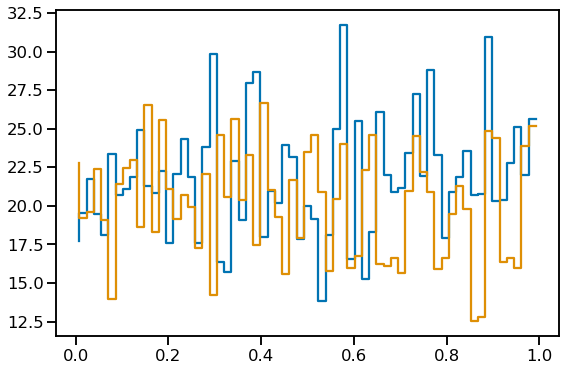

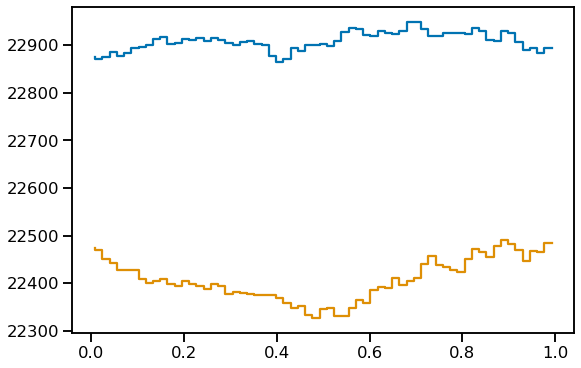

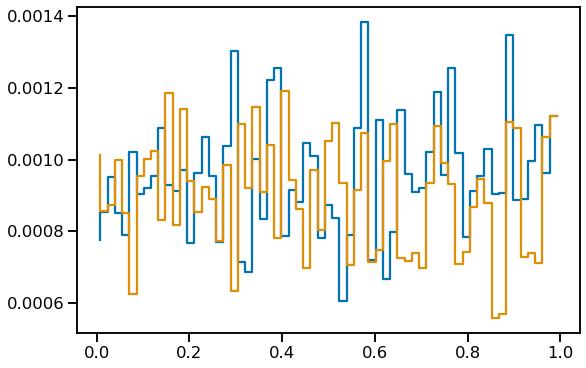

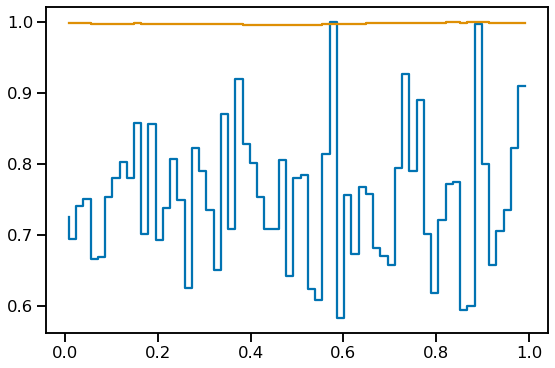

In [11]:
phase_bins_A, profile_A, profile_err_A, livetime_profile_A, z_stat_A = \
        events[0].fold_events_ltcorr(589., time_intervals = burst_gti, \
                                nbin = 64, ref_time = events[0].time[0], region_filter=False, pi_min = 35, pi_max = 260, weight_pos=True)
phase_bins_B, profile_B, profile_err_B, livetime_profile_B, z_stat_B = \
        events[1].fold_events_ltcorr(589., time_intervals = burst_gti, \
                                nbin = 64, ref_time = events[0].time[0], region_filter=False, pi_min = 35, pi_max = 260, weight_pos=True)


# plt.figure(figsize=(9,6))
# plt.step(phase_bins_A, profile_A)
# plt.step(phase_bins_B, profile_B)

# plt.figure(figsize=(9,6))
# plt.step(phase_bins_A, livetime_profile_A)
# plt.step(phase_bins_B, livetime_profile_B)

# plt.figure(figsize=(9,6))
# plt.step(phase_bins_A, profile_A/livetime_profile_A)
# plt.step(phase_bins_B, profile_B/livetime_profile_B)

# plt.figure(figsize=(9,6))
# plt.step(phase_bins_A, (profile_A + profile_B)/(livetime_profile_A + livetime_profile_B)/np.max((profile_A + profile_B)/(livetime_profile_A + livetime_profile_B)))
# plt.step(phase_bins_A, (livetime_profile_A + livetime_profile_B)/np.max(livetime_profile_A + livetime_profile_B))

# plt.figure(figsize=(9,6))
# plt.step(phase_bins_A, (profile_A/livetime_profile_A) + (profile_B/livetime_profile_B))




In [5]:
temp_gtis = []
temp_start = burst1_gti[0][0]
while temp_start + 1.0 < burst1_gti[0][1]:
    temp_gtis.append([temp_start, temp_start + 1.0])
    temp_start += 0.5
    

for x in temp_gtis:
    f_arr_A, z_prob_A = efold_search_ltcorr(events[0], f_min=575., f_max=600., f_steps=1000, time_intervals = [x], nbin = 32, pi_min = 35, pi_max = 260)
    f_arr_B, z_prob_B = efold_search_ltcorr(events[1], f_min=575., f_max=600., f_steps=1000, time_intervals = [x], nbin = 32, pi_min = 35, pi_max = 260)
    
    total_prob = z_prob_A + z_prob_B - (z_prob_A * z_prob_B)
#     print(total_prob)
    
    if np.max(total_prob) > 0.68: 
#         plt.figure(figsize= (9,6))
#         plt.step(f_arr_A, z_prob_A, where='mid')
#         print(np.max(z_prob_A))
#         print(f_arr_A[np.argmax(z_prob_A)])

#         plt.figure(figsize= (9,6))
#         plt.step(f_arr_B, z_prob_B, where='mid')
#         print(np.max(z_prob_B))
#         print(f_arr_B[np.argmax(z_prob_B)])

#         plt.figure(figsize= (9,6))
#         plt.step(f_arr_A, total_prob, where='mid')
        print(np.max(total_prob))
        print(f_arr_A[np.argmax(total_prob)])

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/stats.py:86: RuntimeWarning: underflow encountered in _logp_multitrial_from_single_logp
  np.log10(p1).astype(np.double), n)
  0%|          | 2/1000 [00:00<00:55, 17.96it/s]

0.91342028103451787524
584.1591591591591


  0%|          | 2/1000 [00:00<01:05, 15.24it/s]

0.9039382765336029284
583.6586586586586


  0%|          | 2/1000 [00:00<01:10, 14.11it/s]

0.9392433370895169123
581.006006006006


  0%|          | 2/1000 [00:00<01:19, 12.59it/s]

0.96248621496618570054
577.3523523523523


  0%|          | 1/1000 [00:00<01:42,  9.73it/s]

0.7876515461475912805
596.8468468468468


  0%|          | 2/1000 [00:00<01:03, 15.60it/s]

0.7091923761588657671
593.7937937937938


  0%|          | 2/1000 [00:00<00:58, 17.04it/s]

0.72621118377224413987
588.9389389389389


  0%|          | 2/1000 [00:00<00:59, 16.81it/s]

0.91075526440971356357
583.2082082082082


  0%|          | 2/1000 [00:00<01:15, 13.21it/s]

0.83851892160594868053
592.967967967968


  0%|          | 2/1000 [00:00<01:18, 12.74it/s]

0.78106463686891347553
576.3013013013014


  0%|          | 2/1000 [00:00<01:02, 15.89it/s]

0.8088860806620067345
584.4844844844845


  0%|          | 2/1000 [00:00<01:01, 16.27it/s]

0.7870537546732204459
575.5255255255255


  0%|          | 2/1000 [00:00<01:15, 13.16it/s]

0.766353495706984994
576.926926926927


  0%|          | 2/1000 [00:00<01:05, 15.17it/s]

0.746993831653341267
579.9799799799799


  0%|          | 2/1000 [00:00<01:05, 15.22it/s]

0.8255093816166436671
575.1751751751751


  0%|          | 2/1000 [00:00<01:05, 15.17it/s]

0.78991107552704944994
589.4144144144144


  0%|          | 2/1000 [00:00<01:05, 15.21it/s]

0.7506749022279828043
594.1941941941942


  0%|          | 2/1000 [00:00<01:04, 15.37it/s]

0.7825499455573394769
591.0910910910911


  0%|          | 2/1000 [00:00<01:04, 15.53it/s]

0.8563915009435381087
586.5865865865866


100%|██████████| 1000/1000 [00:57<00:00, 17.49it/s]


In [6]:
temp_gtis = []
temp_start = burst2_gti[0][0]
while temp_start + 1.0 < burst2_gti[0][1]:
    temp_gtis.append([temp_start, temp_start + 1.0])
    temp_start += 0.5


for x in temp_gtis:
    f_arr_A, z_prob_A = efold_search_ltcorr(events[0], f_min=575., f_max=600., f_steps=1000, time_intervals = [x], nbin = 32, pi_min = 35, pi_max = 260)
    f_arr_B, z_prob_B = efold_search_ltcorr(events[1], f_min=575., f_max=600., f_steps=1000, time_intervals = [x], nbin = 32, pi_min = 35, pi_max = 260)
    
    total_prob = z_prob_A + z_prob_B - (z_prob_A * z_prob_B)
#     print(total_prob)
    
    if np.max(total_prob) > 0.68: 
#         plt.figure(figsize= (9,6))
#         plt.step(f_arr_A, z_prob_A, where='mid')
#         print(np.max(z_prob_A))
#         print(f_arr_A[np.argmax(z_prob_A)])

#         plt.figure(figsize= (9,6))
#         plt.step(f_arr_B, z_prob_B, where='mid')
#         print(np.max(z_prob_B))
#         print(f_arr_B[np.argmax(z_prob_B)])

#         plt.figure(figsize= (9,6))
#         plt.step(f_arr_A, total_prob, where='mid')
        print(np.max(total_prob))
        print(f_arr_A[np.argmax(total_prob)]) 

  0%|          | 2/1000 [00:00<01:05, 15.16it/s]

0.7368096732814367611
582.7577577577578


  0%|          | 2/1000 [00:00<01:17, 12.84it/s]

0.9800856564304802898
586.8368368368368


  0%|          | 2/1000 [00:00<01:35, 10.49it/s]

0.6994905453949717966
594.0690690690691


  0%|          | 2/1000 [00:00<01:33, 10.63it/s]

0.80434892498333243616
596.6716716716717


  0%|          | 1/1000 [00:00<01:44,  9.55it/s]

0.71213106393580050124
593.3683683683684


  0%|          | 1/1000 [00:00<01:41,  9.87it/s]

0.83025261705274536195
585.1351351351351


  0%|          | 2/1000 [00:00<01:23, 11.97it/s]

0.7925191061451718477
591.7417417417417


  0%|          | 1/1000 [00:00<01:51,  8.95it/s]

0.8705972160455776043
588.8638638638639


  0%|          | 2/1000 [00:00<01:12, 13.73it/s]

0.88869505924595013123
595.7957957957958


  0%|          | 2/1000 [00:00<01:21, 12.19it/s]

0.9062879215701430402
596.2962962962963


  0%|          | 1/1000 [00:00<01:41,  9.89it/s]

0.82216377993484379694
581.056056056056


  0%|          | 2/1000 [00:00<01:19, 12.53it/s]

0.90616965971241655864
587.9379379379379


  0%|          | 2/1000 [00:00<01:15, 13.14it/s]

0.8878817329245918266
598.8738738738739


  0%|          | 2/1000 [00:00<01:12, 13.69it/s]

0.8777737326902236431
589.8148148148148


  0%|          | 2/1000 [00:00<01:14, 13.33it/s]

0.9927440541370168292
581.7567567567568


  0%|          | 2/1000 [00:00<01:17, 12.85it/s]

0.94531456903420139903
581.981981981982


  0%|          | 2/1000 [00:00<01:09, 14.32it/s]

0.68129145451557959756
598.0980980980981


  0%|          | 2/1000 [00:00<01:25, 11.70it/s]

0.84662788862240093146
594.8198198198198


  0%|          | 2/1000 [00:00<01:17, 12.84it/s]

0.8811397473504983813
595.0200200200201


  0%|          | 2/1000 [00:00<01:18, 12.69it/s]

0.8764684593963990439
575.7757757757757


  0%|          | 2/1000 [00:00<01:07, 14.74it/s]

0.76301795240742154025
595.8208208208208


  0%|          | 2/1000 [00:00<01:14, 13.38it/s]

0.82692279833211435047
581.3063063063063


  0%|          | 2/1000 [00:00<01:09, 14.38it/s]

0.7779896991589107247
580.7807807807808


  0%|          | 2/1000 [00:00<01:09, 14.42it/s]

0.73522506699286871434
586.6116116116116


100%|██████████| 1000/1000 [00:58<00:00, 17.10it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/stats.py:86: RuntimeWarning: underflow encountered in _logp_multitrial_from_single_logp
  np.log10(p1).astype(np.double), n)
100%|██████████| 1000/1000 [01:08<00:00, 14.53it/s]


0.6282203478979344613
566.9693693693694
0.27239295549932307505
566.9881881881881
0.6282203478979344613
566.9693693693694


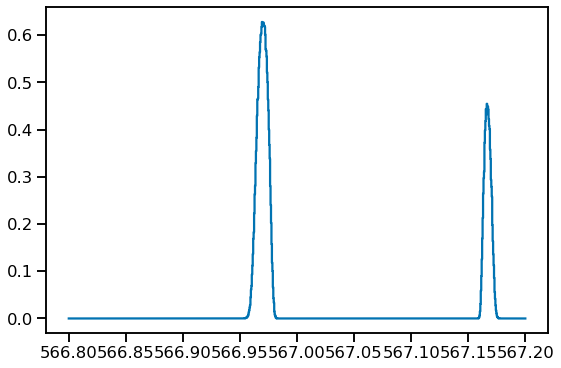

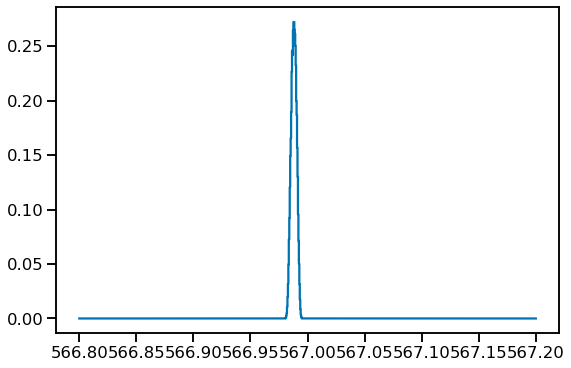

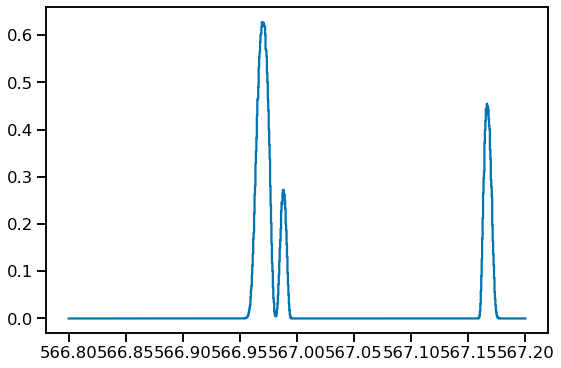

In [37]:
f_arr_A, z_prob_A = efold_search(events[0], f_min=566.8, f_max=567.2, f_steps=1000, time_intervals = burst2_gti, nbin = 32, pi_min = 35, pi_max = 260)
f_arr_B, z_prob_B = efold_search(events[1], f_min=566.8, f_max=567.2, f_steps=1000, time_intervals = burst2_gti, nbin = 32, pi_min = 35, pi_max = 260)
    
plt.figure(figsize= (9,6))
plt.step(f_arr_A, z_prob_A, where='mid')
print(np.max(z_prob_A))
print(f_arr_A[np.argmax(z_prob_A)])

plt.figure(figsize= (9,6))
plt.step(f_arr_B, z_prob_B, where='mid')
print(np.max(z_prob_B))
print(f_arr_B[np.argmax(z_prob_B)])    

total_prob = z_prob_A + z_prob_B - (z_prob_A * z_prob_B)
plt.figure(figsize= (9,6))
plt.step(f_arr_A, total_prob, where='mid')
print(np.max(total_prob))
print(f_arr_A[np.argmax(total_prob)])    

# Persistent Cospectra

In [7]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, persistent_gti)])
len_mask = gti_lens > 500.
split_time = minimize_remainder(gti_lens[len_mask], 500,1500)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [535.45075,442.58818], radius = 40.681706) for x in events[0].split_by_time(bintime=split_time, gti=persistent_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [529.34253,440.82937], radius = 40.681706) for x in events[1].split_by_time(bintime=split_time, gti=persistent_gti)]



530.3030303030303


In [8]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,100.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_10s.time, curve_10s.countrate, xerr=curve_10s.dt/2, yerr=curve_10s.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'persistent_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()
    cross_file = open(timing_dir + 'analysis_products/' + 'persistent_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/55 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  2%|▏         | 1/55 [00:41<37:24, 41.56s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  4%|▎         | 2/55 [01:20<36:03, 40.81s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
  5%|▌         | 3/55 [01:58<34:33, 39.88s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning

In [11]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m

cross_file = open(timing_dir + 'analysis_products/' + 'persistent_cross_spectrum_average.txt', 'wb')
pickle.dump(averaged_cross, cross_file)
cross_file.close()


    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-4,10.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real*averaged_cross_log.freq, xerr=temp_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5)
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),0.5)
plt.ylim((1e-3,10.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((0.3, 2500.))
plt.ylim((1e-4,2.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


# Burst Cospectra

In [12]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, burst_gti)])
split_time = minimize_remainder(gti_lens, 10.,1000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [535.45075,442.58818], radius = 40.681706) for x in events[0].split_by_time(bintime=split_time, gti=burst_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [529.34253,440.82937], radius = 40.681706) for x in events[1].split_by_time(bintime=split_time, gti=burst_gti)]

print(curves_A[0].time)



10.0
[3.26544755e+08 3.26544755e+08 3.26544755e+08 ... 3.26544765e+08
 3.26544765e+08 3.26544765e+08]


In [13]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,1000.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_total.time, curve_total.countrate, xerr=curve_total.dt/2, yerr=curve_total.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'burst_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()

    cross_file = open(timing_dir + 'analysis_products/burst_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/6 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 17%|█▋        | 1/6 [01:06<05:30, 66.16s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 33%|███▎      | 2/6 [02:11<04:23, 65.79s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 50%|█████     | 3/6 [03:16<03:16, 65.61s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SI

In [14]:
## plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-2,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-2,100.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((10.0, 3000.))
plt.ylim((1e-2,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


# Pre-Burst Cospectra

In [24]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, pre_burst1_gti)])
split_time = minimize_remainder(gti_lens, 500.,2000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

PI_min = 35     # 3.0 keV
PI_max = 260     # 12.0 keV

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [535.45075,442.58818], radius = 40.681706) for x in events[0].split_by_time(bintime=split_time, gti=pre_burst1_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [529.34253,440.82937], radius = 40.681706) for x in events[1].split_by_time(bintime=split_time, gti=pre_burst1_gti)]

print(curves_A[0].time)



515.1515151515151
[3.26534755e+08 3.26534755e+08 3.26534755e+08 ... 3.26535270e+08
 3.26535270e+08 3.26535270e+08]


In [25]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,1000.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_10s.time, curve_10s.countrate, xerr=curve_10s.dt/2, yerr=curve_10s.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'preburst1_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()

    cross_file = open(timing_dir + 'analysis_products/preburst1_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/9 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 11%|█         | 1/9 [00:35<04:46, 35.78s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 22%|██▏       | 2/9 [01:15<04:18, 36.96s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 33%|███▎      | 3/9 [01:53<03:43, 37.28s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SI

In [26]:
## plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-4,3.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst1_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-3,3.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst1_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((10.0, 3000.))
plt.ylim((1e-4,3.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst1_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


In [27]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, pre_burst2_gti)])
split_time = minimize_remainder(gti_lens, 500.,2000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

PI_min = 35     # 3.0 keV
PI_max = 260     # 12.0 keV

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [535.45075,442.58818], radius = 40.681706) for x in events[0].split_by_time(bintime=split_time, gti=pre_burst2_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = [529.34253,440.82937], radius = 40.681706) for x in events[1].split_by_time(bintime=split_time, gti=pre_burst2_gti)]

print(curves_A[0].time)



545.4545454545455
[3.26574617e+08 3.26574617e+08 3.26574617e+08 ... 3.26575163e+08
 3.26575163e+08 3.26575163e+08]


In [28]:
plt.ioff()

cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross = crossspec.Crossspectrum(curves_A[i], curves_B[i], norm='leahy')
    cross_spectra.append(cross)
    cross_log = cross.rebin_log(f=f_res)
    temp_err = cross.df*np.power(1.+f_res, range(len(cross_log.freq)))/2
#     cross_lin = cross.rebin(df=1)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
#     res_mask = cross_log.freq > cross.df/f_re
    ax1.errorbar(cross_log.freq, cross_log.power.real, xerr=temp_err, yerr=cross_log.power_err, fmt='none', lw=0.2)
#     ax1.errorbar(cross.freq, cross.power.real*cross.freq, xerr=cross.df/2, yerr=cross.power_err*cross.freq, fmt='')
#     ax1.set_xlim(1./split_time,1./(2.*ms_bin))
#     ax1.axvline(1122, ls='--', color='red')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Leahy power')
    ax1.set_ylim(1e-6,1000.)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.errorbar(curve_10s.time, curve_10s.countrate, xerr=curve_10s.dt/2, yerr=curve_10s.countrate_err, fmt='none')
    ax2.axvspan(np.min(curves_A[i].time),np.max(curves_A[i].time), facecolor='red', alpha = 0.2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(r'$\mathrm{Count\ rate\ (s^{-1})}$')
    plt.tight_layout()
    plt.savefig(plot_dir + 'preburst2_cross_spectrum_log_' + str(int(split_time)) + 's_segment' + str(i) + '.pdf')  
    plt.close()

    cross_file = open(timing_dir + 'analysis_products/preburst2_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'wb')
    pickle.dump(cross, cross_file)
    cross_file.close()
    

  0%|          | 0/8 [00:00<?, ?it/s]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 12%|█▎        | 1/8 [00:42<04:59, 42.72s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 25%|██▌       | 2/8 [01:25<04:15, 42.60s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
 38%|███▊      | 3/8 [02:08<03:33, 42.72s/it]/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SI

In [29]:
## plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
# plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-4,10.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst2_averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((1./split_time) - (averaged_cross.df),10.)
plt.ylim((1e-3,10.0))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst2_averaged_cross_spectrum_' + str(int(split_time)) + 's_lowf.pdf')
plt.close()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.2)
plt.xscale('log')
# plt.xlim((1./split_time) - (averaged_cross.df/2.),1./(2.*ms_bin))
plt.xlim((10.0, 3000.))
plt.ylim((1e-4,3.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst2_averaged_cross_spectrum_' + str(int(split_time)) + 's_highf.pdf')
plt.close()

/Users/sean/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
